## Setup

In [1]:
# Colab Setup
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/Shareddrives/Pottie Group Lab Drive/Research Projects/LAVAE'

# Project Setup
!pip install adabelief-pytorch
!pip install imgaug

import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.utils.data as data
import torch.nn.functional as F

from adabelief_pytorch import AdaBelief

from models import LAVAE, torch_latent_dataloader
import utils as ut

# Auto reload Libraries
%load_ext autoreload
%autoreload 2

# Seed the session
ut.project_seed(0)

# Torch Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

!nvidia-smi

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Shareddrives/Pottie Group Lab Drive/Research Projects/LAVAE
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Wed Jan 25 10:08:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0 

## Arguments

In [2]:
# Paths
experiment_name = 'MNIST_Transfer_1' # Used for checkpoints folder and figure names
AUGS = ['flip_lr', 'flip_ud']
AUGS_2 = ['shearX','canny']

# Data
IMAGE_SIZE = 28
CLASS_FILTER = None  # None or a single class
CHECKPOINTS = 10

# Train Settings
ED_EPOCHS = 100
LA_EPOCHS = 60
E2_EPOCHS = 100

# Model Variables
NUM_DEC = 2
NUM_FILTERS = 128
LATENT_DIM = 8
LATENT_LINEAR = True    

# Loss Weights
LAMBDA_KLD = 5
LAMBDA_Recon = 1
LAMBDA_Invol = 1

## VAE Training

#### Model and Optimizers Init

Train/Test Size: 240000/40000
Model Parameters: 2006290


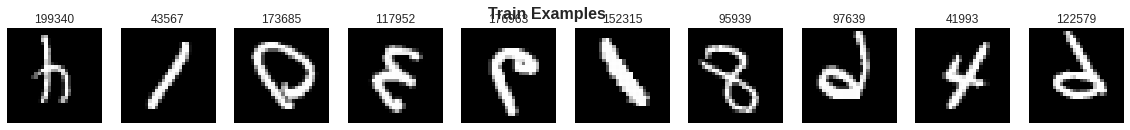

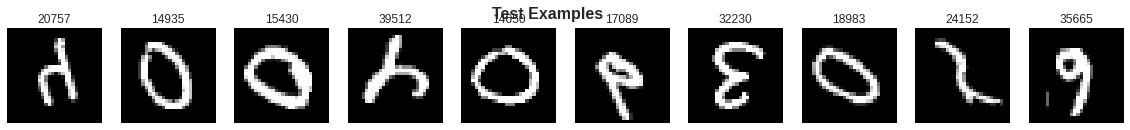

In [3]:
# Create Paths
if not os.path.exists('./checkpoints/{}/'.format(experiment_name)):
   os.makedirs('./checkpoints/{}/'.format(experiment_name))

# Data
train_loader, test_loader = ut.MNIST_data(class_filter=CLASS_FILTER,augs=AUGS,Plot=True)
print('Train/Test Size: {}/{}'.format(len(train_loader.dataset),len(test_loader.dataset)))

# Model
model = LAVAE(num_filters=NUM_FILTERS, latent_dim=LATENT_DIM,image_dim=IMAGE_SIZE,augs=AUGS,num_dec = NUM_DEC,latent_linear=LATENT_LINEAR).to(device)
# Print Number of Parameters
print('Model Parameters: {}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# VAE Optimizer
parameters = list(model.encoder.parameters()) + list(model.decoders[0].parameters())
optimizer_ED = AdaBelief(parameters,lr=1e-3, eps=1e-16, betas=(0.9,0.999), weight_decouple = False, rectify = False,print_change_log = False)

# Augmentation Optimizer
optimizer_LA = AdaBelief(model.Laugs.parameters(),lr=1e-3, eps=1e-16, betas=(0.9,0.999), weight_decouple = False, rectify = False,print_change_log = False)

# Decoder Optimizers
optimizer_D = []
for dec in range(1,len(model.decoders)):
    optimizer_D.append(AdaBelief(model.decoders[dec].parameters(),lr=1e-3, eps=1e-16, betas=(0.9,0.999), weight_decouple = False, rectify = False,print_change_log = False))


Epoch: 10/100, Total Loss: 7506.8381, KLD: 1112.4089 Recon: 6394.4292 Test Loss: 6111.02094062
Epoch: 20/100, Total Loss: 7424.5759, KLD: 1124.6550 Recon: 6299.9210 Test Loss: 6037.08315469
Epoch: 30/100, Total Loss: 7383.7801, KLD: 1130.3201 Recon: 6253.4600 Test Loss: 6009.00675781
Epoch: 40/100, Total Loss: 7359.1866, KLD: 1133.9002 Recon: 6225.2865 Test Loss: 6029.75216563
Epoch: 50/100, Total Loss: 7343.8425, KLD: 1136.8679 Recon: 6206.9746 Test Loss: 5977.38478828
Epoch: 60/100, Total Loss: 7331.2747, KLD: 1138.7940 Recon: 6192.4807 Test Loss: 5971.62578125
Epoch: 70/100, Total Loss: 7321.7215, KLD: 1140.2612 Recon: 6181.4602 Test Loss: 5969.67999766
Epoch: 80/100, Total Loss: 7314.2698, KLD: 1141.5053 Recon: 6172.7645 Test Loss: 6019.62123359
Epoch: 90/100, Total Loss: 7307.4463, KLD: 1142.6224 Recon: 6164.8238 Test Loss: 5960.22088438
Epoch: 100/100, Total Loss: 7303.1453, KLD: 1143.5842 Recon: 6159.5611 Test Loss: 5954.48048984


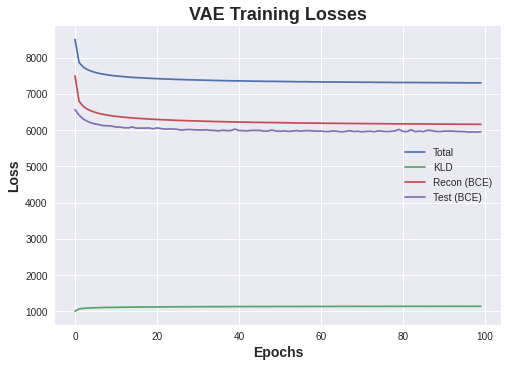

In [4]:
# Store Losses
ED_Losses = {'KLD':[], 
          'Recon':[],
          'Total':[],
          'Test': [],
          }

# Train
for epoch in range(1,ED_EPOCHS+1):
    model.train()

    # Losses
    ED_Losses['KLD'].append(0)
    ED_Losses['Recon'].append(0)
    ED_Losses['Total'].append(0)

    for idx, x in enumerate(train_loader):

        x = x.to(device)
        optimizer_ED.zero_grad()

        x_hat, mu, logvar = model(x)

        loss_KLD = ut.vae_KLD(mu,logvar)
        loss_recon = ut.vae_recon_loss(x, x_hat,image_size=IMAGE_SIZE)
        loss = LAMBDA_KLD * loss_KLD + LAMBDA_Recon * loss_recon
        loss = loss_KLD + loss_recon
        loss.backward()
        optimizer_ED.step()

        ED_Losses['KLD'][-1] += loss_KLD.item()
        ED_Losses['Recon'][-1] += loss_recon.item()
        ED_Losses['Total'][-1] += loss.item()

    # Divide lossed by number of batches
    ED_Losses['KLD'][-1] /= len(train_loader)
    ED_Losses['Recon'][-1] /= len(train_loader)
    ED_Losses['Total'][-1] /= len(train_loader)

    # Test
    ED_Losses['Test'].append(ut.test(model, test_loader, device,image_size=IMAGE_SIZE))
        
    if epoch % CHECKPOINTS == 0:
        print('Epoch: {}/{},'.format(epoch, ED_EPOCHS),
                'Total Loss: {:.4f},'.format(ED_Losses['Total'][-1]),
                'KLD: {:.4f}'.format(ED_Losses['KLD'][-1]),
                'Recon: {:.4f}'.format(ED_Losses['Recon'][-1]),
                'Test Loss: {:.8f}'.format(ED_Losses['Test'][-1]),
                )

        # Save Model
        torch.save(model.state_dict(), './checkpoints/{}/ED_{}.pt'.format(experiment_name,epoch))

# Plot Losses
ut.plot_losses_VAE(ED_Losses,experiment_name=experiment_name)

In [5]:
# Load model
model.load_state_dict(torch.load('checkpoints/{}/ED_{}.pt'.format(experiment_name,ED_EPOCHS)))

<All keys matched successfully>

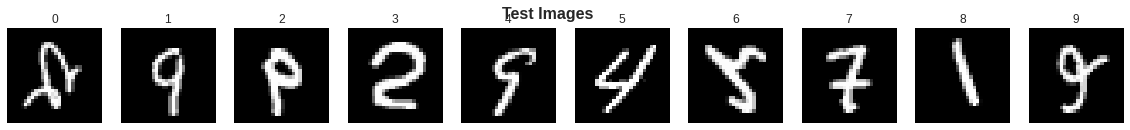

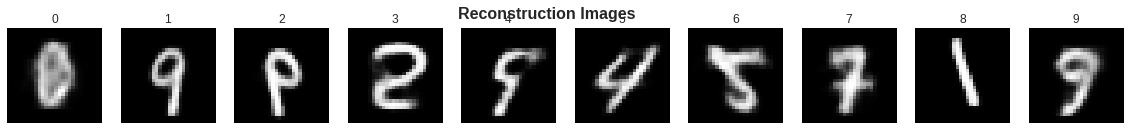

In [6]:
# Plot Test Results
images = next(iter(test_loader))[0:10,:,:]

with torch.no_grad():
    model.eval()
    x_hat,z,_ = model(images.reshape(10,1,IMAGE_SIZE,IMAGE_SIZE).to(device).type(torch.float32))

ut.plot_images(images.detach().cpu().numpy(), indices = [*range(10)], image_dim = 28, title = 'Test Images')
ut.plot_images(x_hat.detach().cpu().numpy(), indices = [*range(10)], image_dim = 28, title = 'Reconstruction Images')


## Latent Augment Train

Train/Test Size: 60000/10000


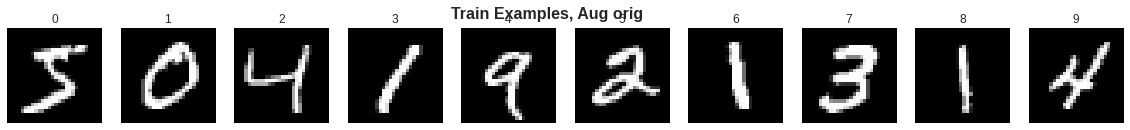

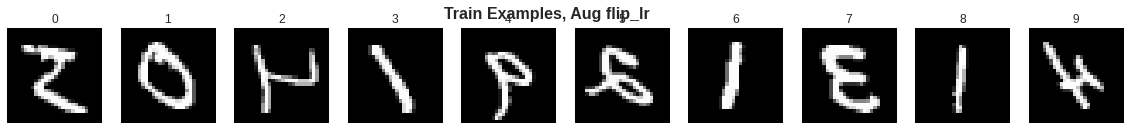

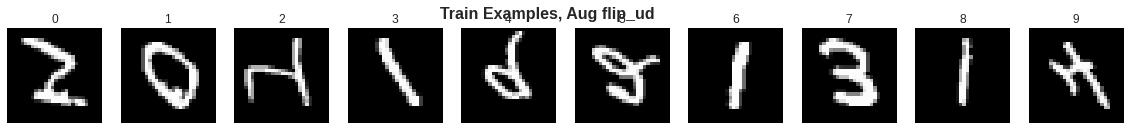

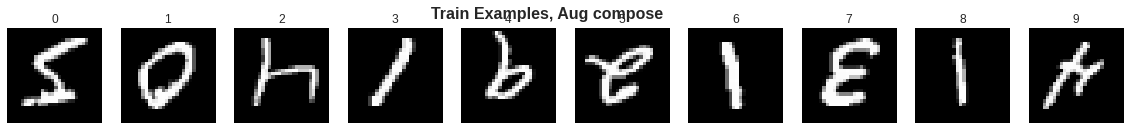

In [7]:
# Data
train_loader, test_loader = ut.MNIST_data(class_filter=CLASS_FILTER,augs=['flip_lr', 'flip_ud'], combine=False, Plot=True)
print('Train/Test Size: {}/{}'.format(len(train_loader.dataset),len(test_loader.dataset)))

In [8]:
# Store Losses
LA_losses = {'MSE':[], 
          'Invol':[],
          'Total':[],
          'Test': [],
          }

# Loss Reconstruction
MSE_latent = torch.nn.MSELoss()

# Train
for epoch in range(1,LA_EPOCHS+1):

    # Losses
    LA_losses['MSE'].append(0)
    LA_losses['Invol'].append(0)
    LA_losses['Total'].append(0)

    for idx, imgs in enumerate(train_loader):

        for aug in imgs.keys(): 
            imgs[aug] = imgs[aug].to(device)


        with torch.no_grad():
            model.eval()
            z = {k: model(v)[1] for k,v in imgs.items()}

        model.train()
        optimizer_LA.zero_grad()
        
        z_hat = {aug: z['orig'] @ model.Laugs[aug]  for aug in AUGS}

        mse_loss = sum([MSE_latent(z_hat[aug], z[aug]) for aug in AUGS])
        invol_loss = ut.invol_loss(model,device)

        loss = mse_loss + LAMBDA_Invol * invol_loss

        loss.backward()
        optimizer_LA.step()

        LA_losses['MSE'][-1] += mse_loss.item()
        LA_losses['Invol'][-1] += invol_loss.item()
        LA_losses['Total'][-1] += loss.item()

    # Divide lossed by number of batches
    LA_losses['MSE'][-1] /= len(train_loader)
    LA_losses['Invol'][-1] /= len(train_loader)
    LA_losses['Total'][-1] /= len(train_loader)

    # Test
    test_loss = ut.test_laug(model, test_loader, device,num_dec=0, image_size=IMAGE_SIZE)
        
    if epoch % CHECKPOINTS == 0:
        print('Epoch: {}/{},'.format(epoch, LA_EPOCHS),
                'MSE,Invol,Total Loss: {:.4f},{:.4f},{:.4f},'.format(LA_losses['MSE'][-1],
                                                                     LA_losses['Invol'][-1],
                                                                     LA_losses['Total'][-1]),
                'Test Loss: {:.8f}'.format(test_loss),
                )

        # Save Model
        torch.save(model.state_dict(), 'checkpoints/{}/LA_{}.pt'.format(experiment_name, epoch))

Epoch: 10/60, MSE,Invol,Total Loss: 1.0946,0.0206,1.1152, Test Loss: 441.96533203
Epoch: 20/60, MSE,Invol,Total Loss: 1.0943,0.0206,1.1149, Test Loss: 441.80014038
Epoch: 30/60, MSE,Invol,Total Loss: 1.0943,0.0206,1.1149, Test Loss: 441.80007935
Epoch: 40/60, MSE,Invol,Total Loss: 1.0943,0.0206,1.1149, Test Loss: 441.80014038
Epoch: 50/60, MSE,Invol,Total Loss: 1.0943,0.0206,1.1149, Test Loss: 441.80007935
Epoch: 60/60, MSE,Invol,Total Loss: 1.0943,0.0206,1.1149, Test Loss: 441.80007935


### Laug Test Results

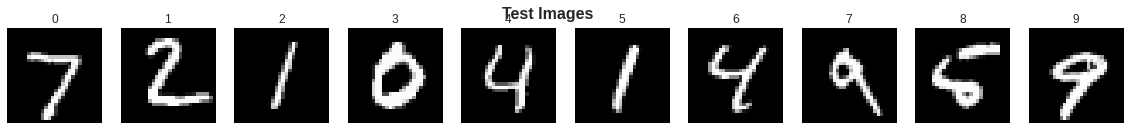

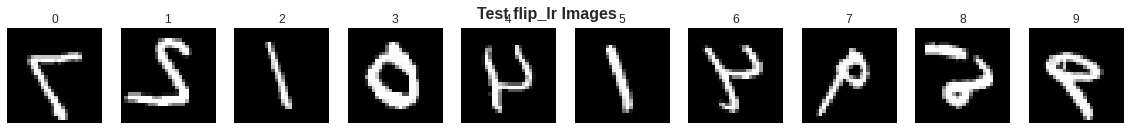

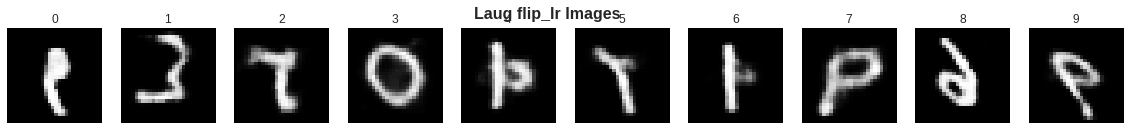

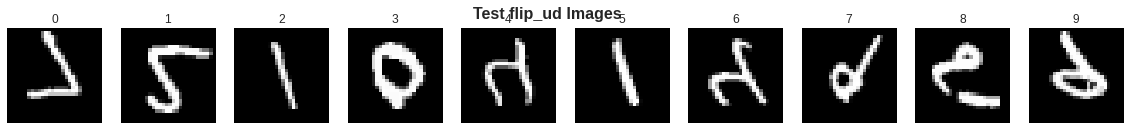

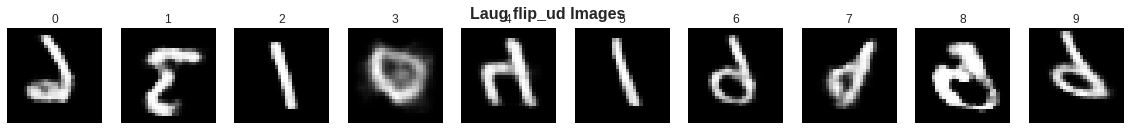

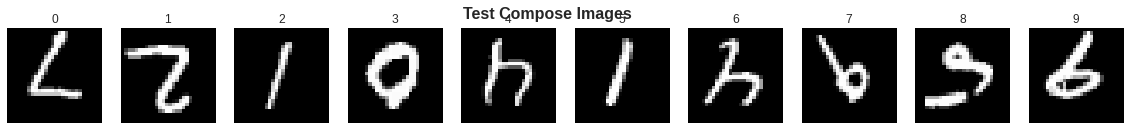

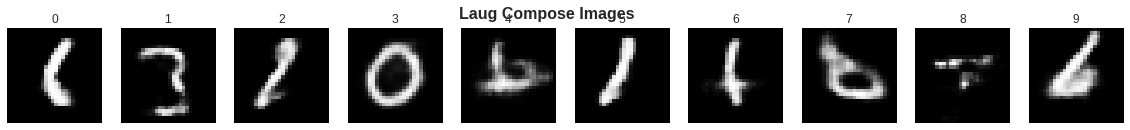

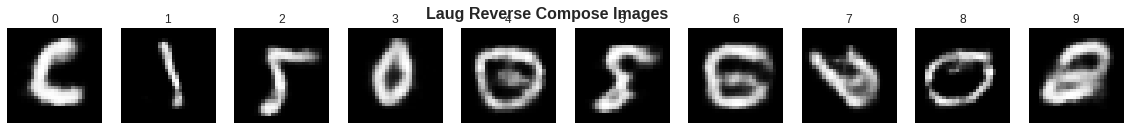

In [9]:
# Plot a few examples of latent transformer

# Data
image_orig = next(iter(test_loader))['orig'][0:10,:,:]
image_aug1 = next(iter(test_loader))[AUGS[0]][0:10,:,:]
image_aug2 = next(iter(test_loader))[AUGS[1]][0:10,:,:]
image_compose = next(iter(test_loader))['compose'][0:10,:,:]


with torch.no_grad():
    model.eval()
    x_hat = {}
    z = {}
    for aug in imgs.keys(): 
        image_orig = image_orig.to(device)
        x_hat, z, _ = model(image_orig)
    x_laugs = {a: model.decoders[0](z @ model.Laugs[a]) for a in model.augs}

    x_laugs['compose'] =  model.decoders[0](z @ model.Laugs[AUGS[0]] @ model.Laugs[AUGS[1]])
    x_laugs['compose_reverse'] =  model.decoders[0](z @ model.Laugs[AUGS[1]] @ model.Laugs[AUGS[0]])


ut.plot_images(image_orig.detach().cpu().numpy(), indices = np.arange(10), image_dim = 28, title = 'Test Images')
ut.plot_images(image_aug1.detach().cpu().numpy(), indices = np.arange(10), image_dim = 28, title = 'Test flip_lr Images')
ut.plot_images(x_laugs['flip_lr'].detach().cpu().numpy(), indices = np.arange(10), image_dim = 28, title = 'Laug flip_lr Images')
ut.plot_images(image_aug2.detach().cpu().numpy(), indices = np.arange(10), image_dim = 28, title = 'Test flip_ud Images')
ut.plot_images(x_laugs['flip_ud'].detach().cpu().numpy(), indices = np.arange(10), image_dim = 28, title = 'Laug flip_ud Images')
ut.plot_images(image_compose.detach().cpu().numpy(), indices = np.arange(10), image_dim = 28, title = 'Test Compose Images')
ut.plot_images(x_laugs['compose'].detach().cpu().numpy(), indices = np.arange(10), image_dim = 28, title = 'Laug Compose Images')
ut.plot_images(x_laugs['compose_reverse'].detach().cpu().numpy(), indices = np.arange(10), image_dim = 28, title = 'Laug Reverse Compose Images')

## Decoder 2 Training

Train/Test Size: 60000/10000


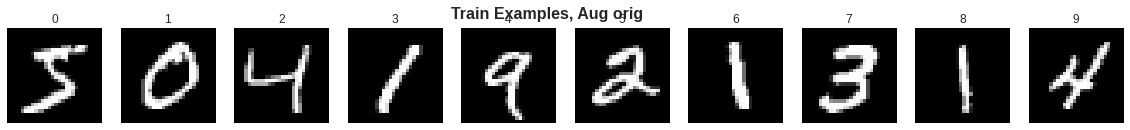

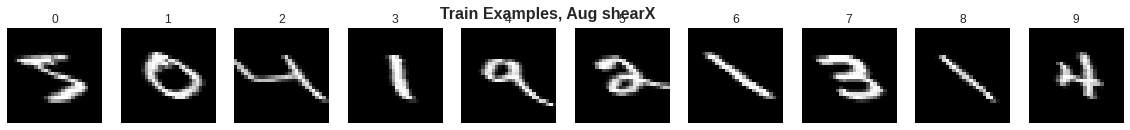

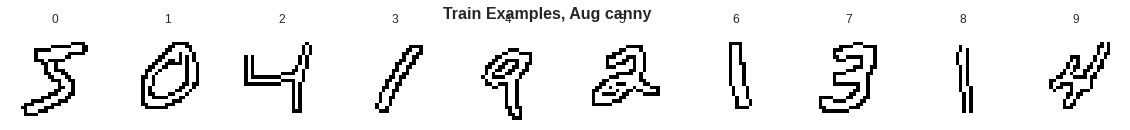

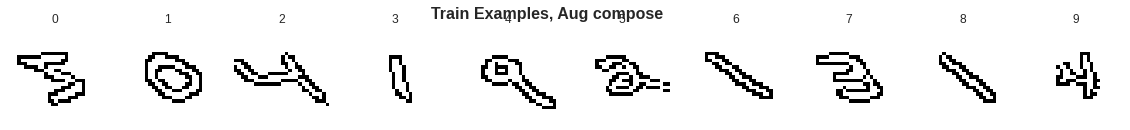

In [10]:
# Data
train_loader, test_loader = ut.MNIST_data(class_filter=CLASS_FILTER,augs=['shearX', 'canny'], combine=False, Plot=True)
print('Train/Test Size: {}/{}'.format(len(train_loader.dataset),len(test_loader.dataset)))

In [11]:
# Store Losses
E2_losses = []

# Train
for epoch in range(1,E2_EPOCHS+1):

    # Losses
    E2_losses.append(0)

    for idx, imgs in enumerate(train_loader):

        z = {}

        for aug in imgs.keys(): 
            imgs[aug] = imgs[aug].to(device)

        with torch.no_grad():
            model.eval()

            z['orig'] = model(imgs['orig'])[1]
            z['shearX'] = z['orig'] @ model.Laugs['flip_lr']
            z['canny'] = z['orig'] @ model.Laugs['flip_ud']
            z['compose'] = z['orig'] @ model.Laugs['flip_lr'] @ model.Laugs['flip_ud']

        model.train()
        optimizer_D[0].zero_grad()

        x_laugs['orig'] = model.decoders[1](z['orig'])
        x_laugs['shearX'] = model.decoders[1](z['shearX'])
        x_laugs['canny'] = model.decoders[1](z['canny'])
        x_laugs['compose'] = model.decoders[1](z['compose'])

        loss = sum([ut.vae_recon_loss(imgs[aug], x_laugs[aug],image_size=IMAGE_SIZE) for aug in imgs.keys()])
        

        loss.backward()
        optimizer_D[0].step()

        E2_losses[-1] += loss.item()

    # Divide lossed by number of batches
    E2_losses[-1] /= len(train_loader)

    # # Test
    # test_loss = ut.test_laug(model, test_loader, device,num_dec=0, image_size=IMAGE_SIZE)
        
    if epoch % CHECKPOINTS == 0:
        print('Epoch: {}/{},'.format(epoch, LA_EPOCHS),
                'Tain Loss: {:.4f},'.format(E2_losses[-1]),
                # 'Test Loss: {:.8f}'.format(test_loss),
                )

        # Save Model
        torch.save(model.state_dict(), 'checkpoints/{}/E2_{}.pt'.format(experiment_name, epoch))

Epoch: 10/60, Tain Loss: 60086.1257,
Epoch: 20/60, Tain Loss: 58150.5011,
Epoch: 30/60, Tain Loss: 57228.3137,
Epoch: 40/60, Tain Loss: 56654.8531,
Epoch: 50/60, Tain Loss: 56236.2282,
Epoch: 60/60, Tain Loss: 55915.2987,
Epoch: 70/60, Tain Loss: 55659.5674,
Epoch: 80/60, Tain Loss: 55447.7060,
Epoch: 90/60, Tain Loss: 55273.6895,
Epoch: 100/60, Tain Loss: 55123.3679,


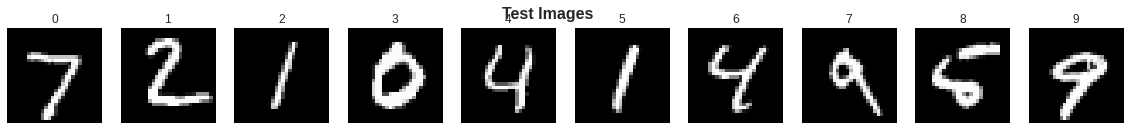

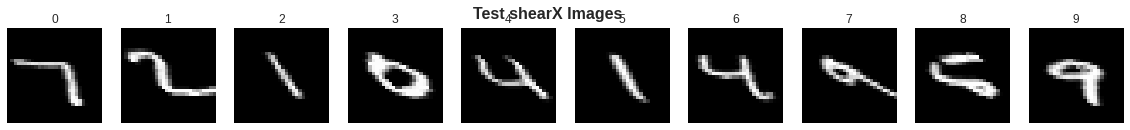

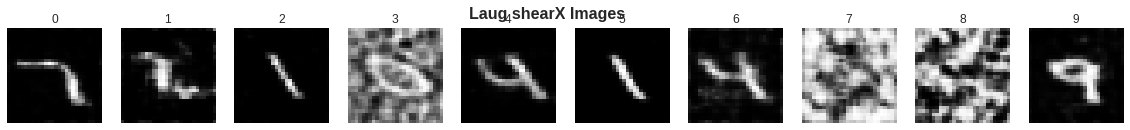

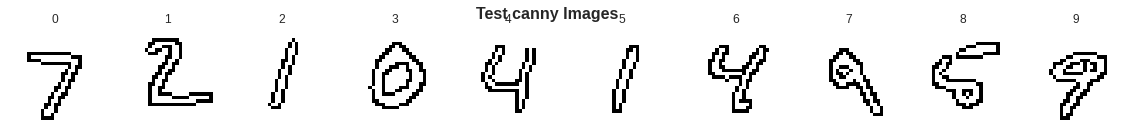

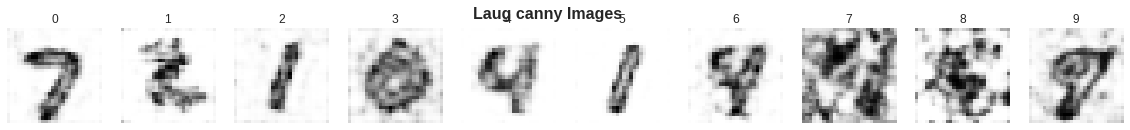

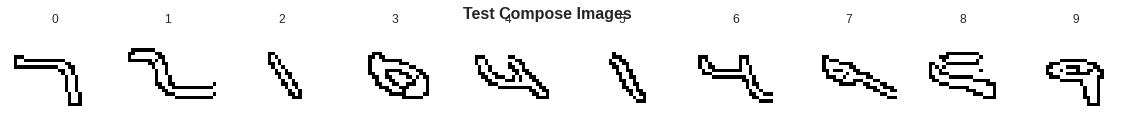

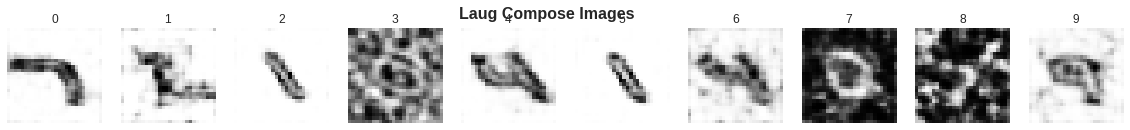

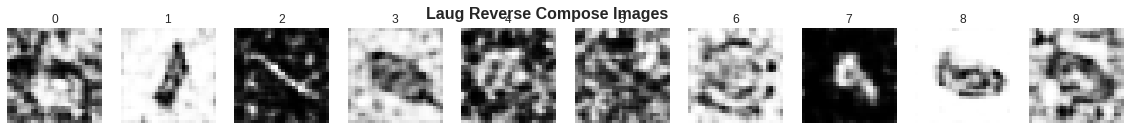

In [12]:
# Plot a few examples of latent transformer

# Data
image_orig = next(iter(test_loader))['orig'][0:10,:,:]
image_aug1 = next(iter(test_loader))['shearX'][0:10,:,:]
image_aug2 = next(iter(test_loader))['canny'][0:10,:,:]
image_compose = next(iter(test_loader))['compose'][0:10,:,:]


with torch.no_grad():
    model.eval()
    x_hat = {}
    z = {}
    for aug in imgs.keys(): 
        image_orig = image_orig.to(device)
        x_hat, z, _ = model(image_orig)
    x_laugs = {a: model.decoders[1](z @ model.Laugs[a]) for a in model.augs}

    x_laugs['compose'] =  model.decoders[1](z @ model.Laugs[AUGS[0]] @ model.Laugs[AUGS[1]])
    x_laugs['compose_reverse'] =  model.decoders[1](z @ model.Laugs[AUGS[1]] @ model.Laugs[AUGS[0]])


ut.plot_images(image_orig.detach().cpu().numpy(), indices = np.arange(10), image_dim = 28, title = 'Test Images')
ut.plot_images(image_aug1.detach().cpu().numpy(), indices = np.arange(10), image_dim = 28, title = 'Test shearX Images')
ut.plot_images(x_laugs['flip_lr'].detach().cpu().numpy(), indices = np.arange(10), image_dim = 28, title = 'Laug shearX Images')
ut.plot_images(image_aug2.detach().cpu().numpy(), indices = np.arange(10), image_dim = 28, title = 'Test canny Images')
ut.plot_images(x_laugs['flip_ud'].detach().cpu().numpy(), indices = np.arange(10), image_dim = 28, title = 'Laug canny Images')
ut.plot_images(image_compose.detach().cpu().numpy(), indices = np.arange(10), image_dim = 28, title = 'Test Compose Images')
ut.plot_images(x_laugs['compose'].detach().cpu().numpy(), indices = np.arange(10), image_dim = 28, title = 'Laug Compose Images')
ut.plot_images(x_laugs['compose_reverse'].detach().cpu().numpy(), indices = np.arange(10), image_dim = 28, title = 'Laug Reverse Compose Images')

## Distance Metric

In [13]:
images = next(iter(test_loader))[0]

with torch.no_grad():
    model.eval()
    x_hat,z,_ = model(images.reshape(images.shape[0],1,IMAGE_SIZE,IMAGE_SIZE).to(device).type(torch.float32))
    z_hat_flip = z @ model.Laug
    # z_hat_hat = model.Laug(z_hat_flip)
    x_hat_flip = model.decoder(z_hat_flip)

In [14]:
train_size  = train_loader.dataset.flipped_data.shape[0]
test_size = test_loader.dataset.flipped_data.shape[0]
# MSE loss
MSE = torch.nn.MSELoss()

trains_distances = []
test_distances = []
for test_image in x_hat_flip:

    # Sample train and test images
    train_idxs = np.random.choice(range(train_size),32,replace=False)
    test_idxs = np.random.choice(range(test_size),32,replace=False)

    train_compare = torch.from_numpy(train_loader.dataset.flipped_data[test_idxs]).type(torch.float32)
    test_compare = torch.from_numpy(test_loader.dataset.flipped_data[test_idxs]).type(torch.float32)

    trains_distances.append(MSE(test_image.repeat(32,1,1),train_compare).item())
    test_distances.append(MSE(test_image.repeat(32,1,1),test_compare).item())

In [15]:
import seaborn as sns

sns.histplot(trains_distances, label='Train',kde=True)
sns.histplot(test_distances, label='Test',kde=True)
plt.legend()
plt.xlabel('MSE', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.title('MSE Laug Flipped vs Train/Test Flipped\nRandom 32 Samples of Each Per Image', fontsize=14, fontweight='bold')